In [518]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import cv2

In [519]:
tf_model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])

tf_model.build([None, 224, 224, 3])

def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

# Which pixels have the strongest effect on models predicted class probabilities
def compute_gradients(tf_model, images, target_class_idx, threshold=0.5):
    # Records gradients between predicted probabilities with each interpolated image
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = tf_model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]

    return tape.gradient(probs, images)

@tf.function
def one_batch(tf_model, baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(tf_model=tf_model, images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

def integrated_gradients(tf_model, baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)

    gradient_batch = compute_gradients(tf_model=tf_model, images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients


  print(integrated_gradients)

  return integrated_gradients

def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

def top_k_predictions(img, k):
  image_batch = tf.expand_dims(img, 0)
  predictions = tf_model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

In [520]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):



  # attributions = attributions.numpy().squeeze()



  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.


  fig, axs = plt.subplots(nrows=10, ncols=1, squeeze=False, figsize=(100, 100))

  pred_label, pred_prob = top_k_predictions(tensor, 10)

  # for label, prob in zip(pred_label, pred_prob):
  #   print()

  # axs[0, 0].set_title("Baseline")
  # axs[0, 0].imshow(baseline, cmap=cmap)
  # axs[0, 0].axis('off')
  #
  # axs[1, 0].set_title("Original Image")
  # axs[1, 0].imshow(image, cmap=cmap)
  # axs[1, 0].axis('off')

  for i in range(10):
    attributions = integrated_gradients(tf_model=tf_model, baseline=baseline,
                                    image=image,
                                    target_class_idx=i,
                                    m_steps=m_steps)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    axs[i, 0].set_title(f'{pred_label[i]}: {pred_prob[i]:0.1%}')
    axs[i, 0].imshow(attribution_mask, cmap=cmap)
    axs[i, 0].axis('off')

  plt.tight_layout()
  return fig


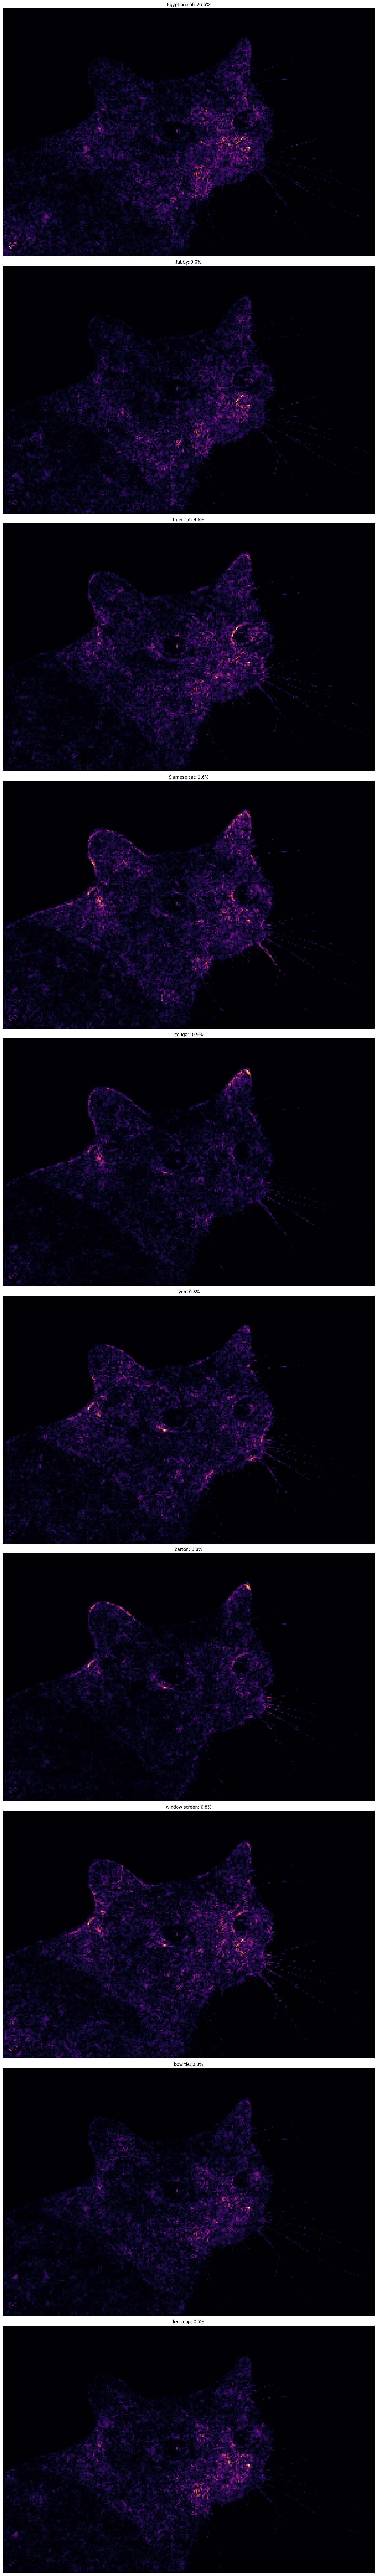

tf.Tensor(
[[[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  [-0.0000000e+00  0.0000000e+00 -0.0000000e+00]]

 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  ...
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  [-0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 [[-0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-0.0000000e+00 -0.0000000e+00  0.0000000e+00]
  [-0.0000000e+00  0.0000000e+00  0.0000000e+00]
  ...
  [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00]
  [-0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 ...

 [[ 2.1479361e-06  1.5564700e-06 -2.2469164e-06]
  [ 7.8479189e-07  4.4015746

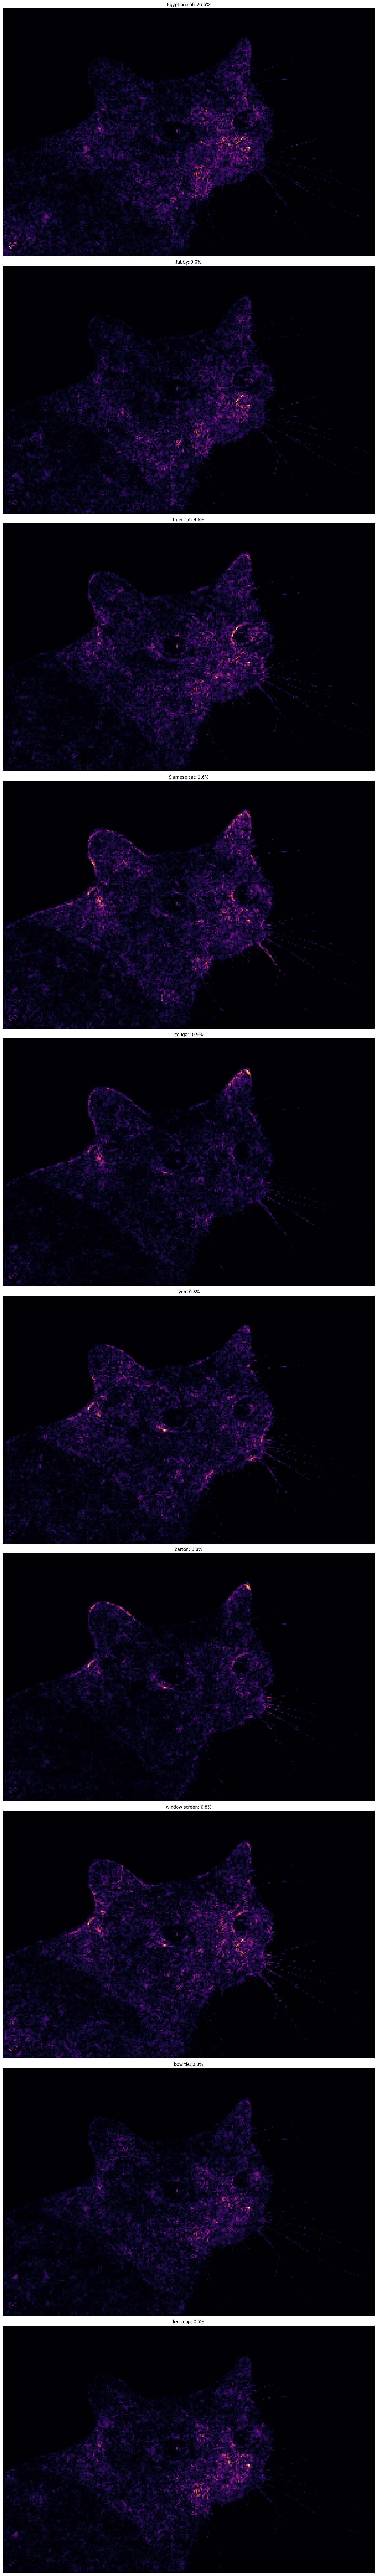

In [521]:
import cv2
from PIL import Image
import numpy as np

baseline = tf.zeros(shape=(200,300,3))
# video = cv2.VideoCapture('video.mp4')
# fps = video.get(cv2.CAP_PROP_FPS)
# print('frames per second =',fps)
# minutes = 0
# seconds = 28
# frame_id = int(fps*(minutes*60 + seconds))
# print('frame id =',frame_id)
# video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
# ret, frame = video.read()
# print(frame.shape)
# cv2.imshow('frame', frame); cv2.waitKey(0)
# cv2.imwrite('my_video_frame.png', frame)
img = tf.io.read_file("frame.png")
tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
tensor = tf.image.resize(tensor, [200, 300])

# image = tf.image.convert_image_dtype(frame, dtype=tf.float32, saturate=False, name=None)
_ = plot_img_attributions(image=tensor,
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=50,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)


